In [1]:
# Import Libraries

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import itertools
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Declare Path for Datasets

train_path = "Covid Dataset/train"
test_path = "Covid Dataset/test"
valid_path = "Covid Dataset/validation/"

In [3]:
# Creating train, test and valid batches from the respective directories
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10)


Found 249 images belonging to 3 classes.
Found 65 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [4]:
# plot sample images in the form of a 1 by 10 grid and resize img to 20x20
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

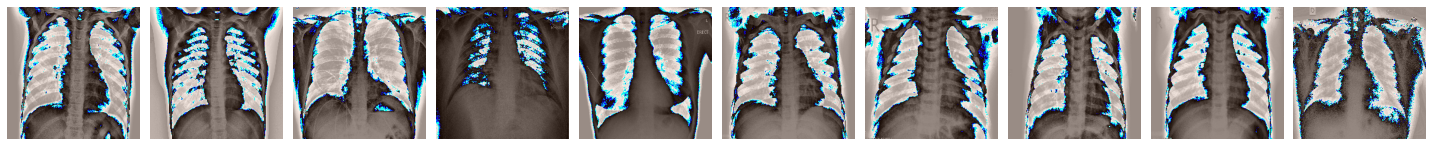

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [5]:
# Show sample training images with labels according to class
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [6]:
#Define Model

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=3, activation='softmax')
    ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 3)                 6

In [7]:
#Compile Model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# recall that we set batch_size = 10 during preprocessing
batch_size = 10 

#Fit the Model
history = model.fit(
    x = train_batches, 
    steps_per_epoch=train_batches.samples // batch_size, 
    epochs=10, 
    validation_data=test_batches, 
    validation_steps=test_batches.samples // batch_size,
    verbose=2)

Epoch 1/10
24/24 - 16s - loss: 14.0455 - accuracy: 0.7406 - val_loss: 12.2225 - val_accuracy: 0.8167 - 16s/epoch - 679ms/step
Epoch 2/10
24/24 - 15s - loss: 2.8802 - accuracy: 0.9121 - val_loss: 11.1519 - val_accuracy: 0.8333 - 15s/epoch - 613ms/step
Epoch 3/10
24/24 - 13s - loss: 1.7482 - accuracy: 0.9414 - val_loss: 7.2059 - val_accuracy: 0.8833 - 13s/epoch - 546ms/step
Epoch 4/10
24/24 - 13s - loss: 0.2882 - accuracy: 0.9833 - val_loss: 11.5791 - val_accuracy: 0.8000 - 13s/epoch - 534ms/step
Epoch 5/10
24/24 - 13s - loss: 0.7829 - accuracy: 0.9707 - val_loss: 17.5832 - val_accuracy: 0.7500 - 13s/epoch - 543ms/step
Epoch 6/10
24/24 - 13s - loss: 1.6298 - accuracy: 0.9331 - val_loss: 11.1572 - val_accuracy: 0.8167 - 13s/epoch - 547ms/step
Epoch 7/10
24/24 - 14s - loss: 9.0470e-07 - accuracy: 1.0000 - val_loss: 13.9670 - val_accuracy: 0.8667 - 14s/epoch - 575ms/step
Epoch 8/10
24/24 - 13s - loss: 0.1002 - accuracy: 0.9958 - val_loss: 11.2810 - val_accuracy: 0.7500 - 13s/epoch - 529ms/s

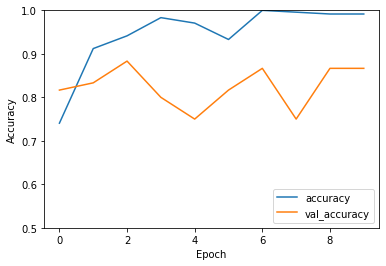

In [9]:
#Graphing our training and validation metrics
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [10]:
# making predictions
predictions = model.predict(x = test_batches, verbose=0)

In [11]:
#Define Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')       

Text(0.5, 6.800000000000011, 'Predicted label')

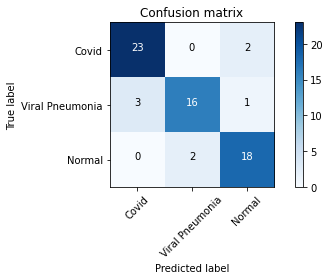

In [12]:
# Display confusion matrix of Predictions against True Labels
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = ['Covid', 'Viral Pneumonia', 'Normal'])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [13]:
# Give diagnosis for validation data set

classes = ['C','V', 'N']

lbl = []
out = []

# Create for loop to access every jpeg in directory 
for i in os.listdir(valid_path):
    val_img = tf.keras.utils.load_img(valid_path+i,target_size=(224,224))
    val_img = tf.keras.utils.img_to_array(val_img)
    val_img = np.expand_dims(val_img,axis=0)
    predict_x=model.predict(val_img)
    output = classes[np.argmax(predict_x)]
    lbl.append(i)
    out.append(output)
    print("Picture #", i,"\n Diagnosis: ", output)



1/1 [==============================] - 0s 69ms/step
Picture # pic1.jpeg 
 Diagnosis:  N
1/1 [==============================] - 0s 25ms/step
Picture # pic10.jpeg 
 Diagnosis:  N
1/1 [==============================] - 0s 25ms/step
Picture # pic2.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 25ms/step
Picture # pic3.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 26ms/step
Picture # pic4.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 25ms/step
Picture # pic5.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 25ms/step
Picture # pic6.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 25ms/step
Picture # pic7.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 26ms/step
Picture # pic8.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 25ms/step
Picture # pic9.jpeg 
 Diagnosis:  C


In [14]:
# Combine lists and create DataFrame
lbl = pd.DataFrame(lbl, columns = ["Picture #"])
out = pd.DataFrame(out, columns = ['Diagnosis'])

final_output = pd.concat([lbl, out], axis = 1)
final = final_output.set_index("Picture #")

In [16]:
# Extract output dataframe to .csv file
final.to_csv('mercado_covid_output.csv')